<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/Gan_%EC%B2%AB%EA%B1%B8%EC%9D%8C/CelebA_CNN_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [4]:
with h5py.File('mount/MyDrive/CelebA/celeba_aligned_small.h5py', 'r') as file_object:
  for group in file_object:
    print(group)

img_align_celeba


In [5]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

### 이미지 전처리
- 편의를 위해 217 * 178 픽셀의 이미지를 128 * 128로 변환
  - center crop

In [6]:
def crop_center(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return img[  starty:starty + new_height, startx:startx + new_width, :]

### Dataset Class
- 기존 데이터셋 클래스에 crop 함수 추가



In [7]:
class CelebADataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        img = crop_center(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0

    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        img = crop_center(img, 128, 128)
        plt.imshow(img, interpolation='nearest')

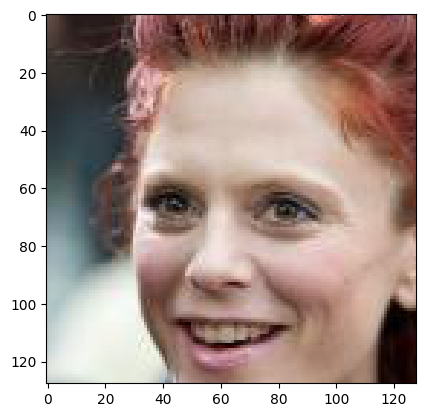

In [8]:
celeba_dataset = CelebADataset('mount/MyDrive/CelebA/celeba_aligned_small.h5py')
celeba_dataset.plot_image(1)

### 판별기
- 합성곱 커널 3개
  - Kernel_size = 8, stride = 2
- Dense Layer 1개

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            # input shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.LeakyReLU(0.2),

            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )

        # 손실함수 및 옵티마이저 설정
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 훈련과정 추적을 위한 변수
        self.counter = 0;
        self.progress = []


    def forward(self, inputs):
        return self.model(inputs)


    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        # loss 계산
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)

        # 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


In [10]:
%%time
D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 6min 28s, sys: 5.25 s, total: 6min 33s
Wall time: 7min 12s


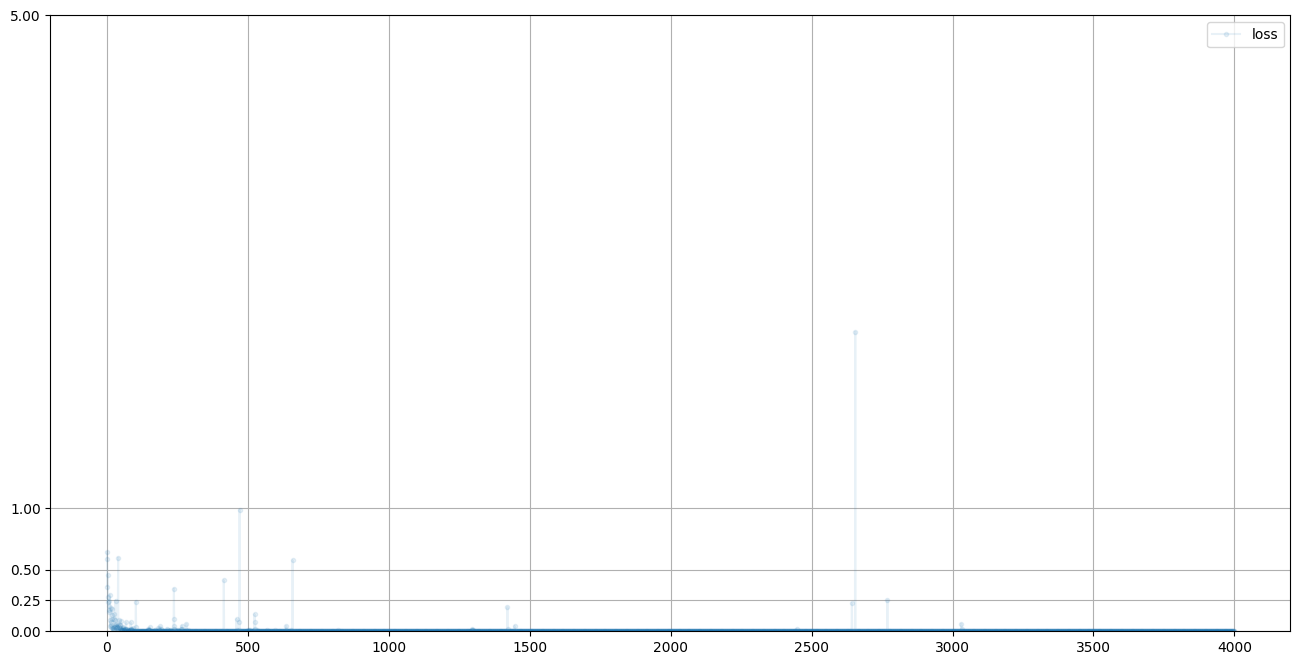

In [11]:
D.plot_progress()

- 0을 향해 빠르게 수렴
- 노이즈도 적음

### 생성기
- 기존 합성곱 Conv2d
  - 큰 텐서를 작은 텐서로 변환
- 전치 합성곱 ConvTranspose2d
  - 합성곱의 반대 방향

- 100개의 시드값을 3 * 11 * 11 값으로 매핑
- 이후 3번의 전치합성곱을 통해 128 * 128 이미지 생성

In [12]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        # 신경망 모델
        self.model = nn.Sequential(
            nn.Linear(100, 3*11*11),
            nn.LeakyReLU(0.2),
            View((1, 3, 11, 11)),

            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),

            # output shape (1,3,128,128)
            nn.Sigmoid()
        )

        # 옵티마이저 설정
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # 생성기 출력 계산
        g_outputs = self.forward(inputs)

        # 생성기 출력값을 판별기로 전달
        d_outputs = D.forward(g_outputs)

        # 오차 계산
        loss = D.loss_function(d_outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        # 기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


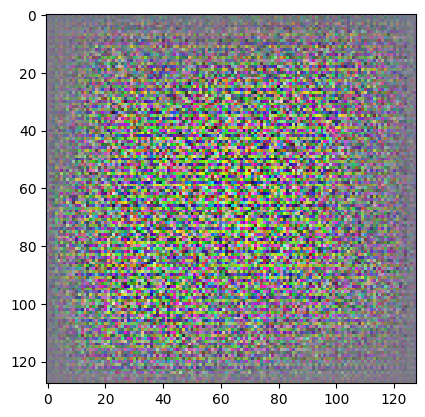

In [13]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [14]:
%%time

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 5

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train
  for image_data_tensor in celeba_dataset:
    # 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

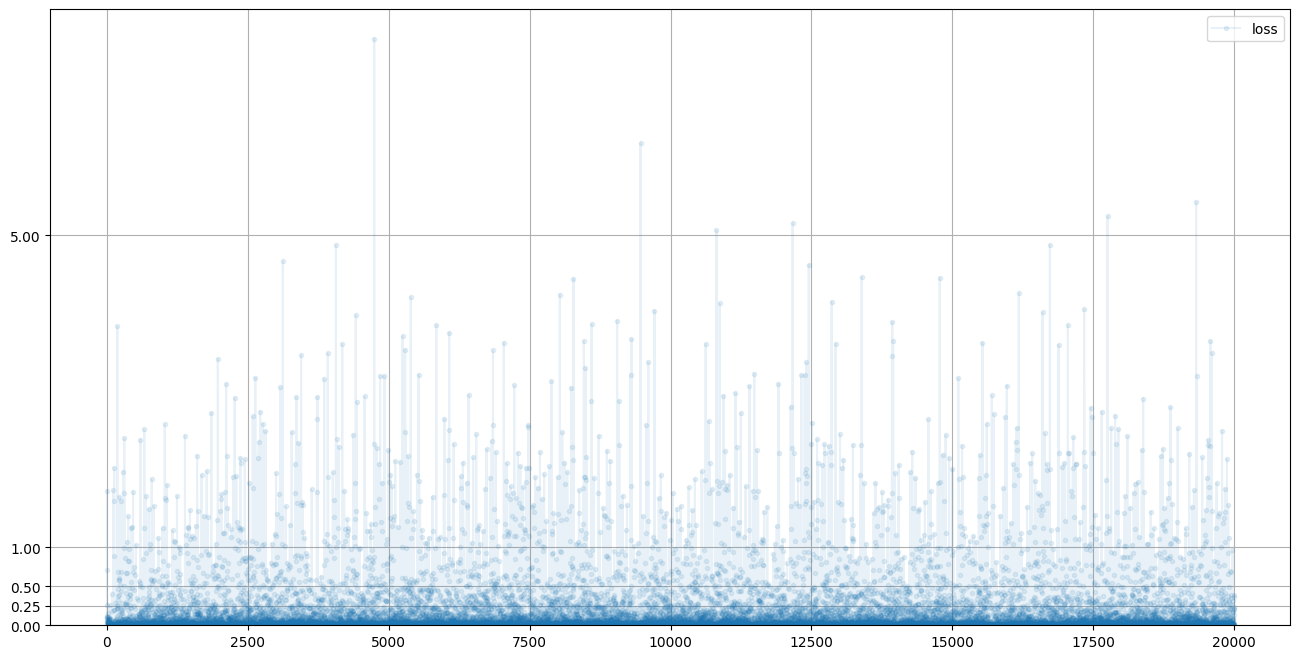

In [15]:
D.plot_progress()

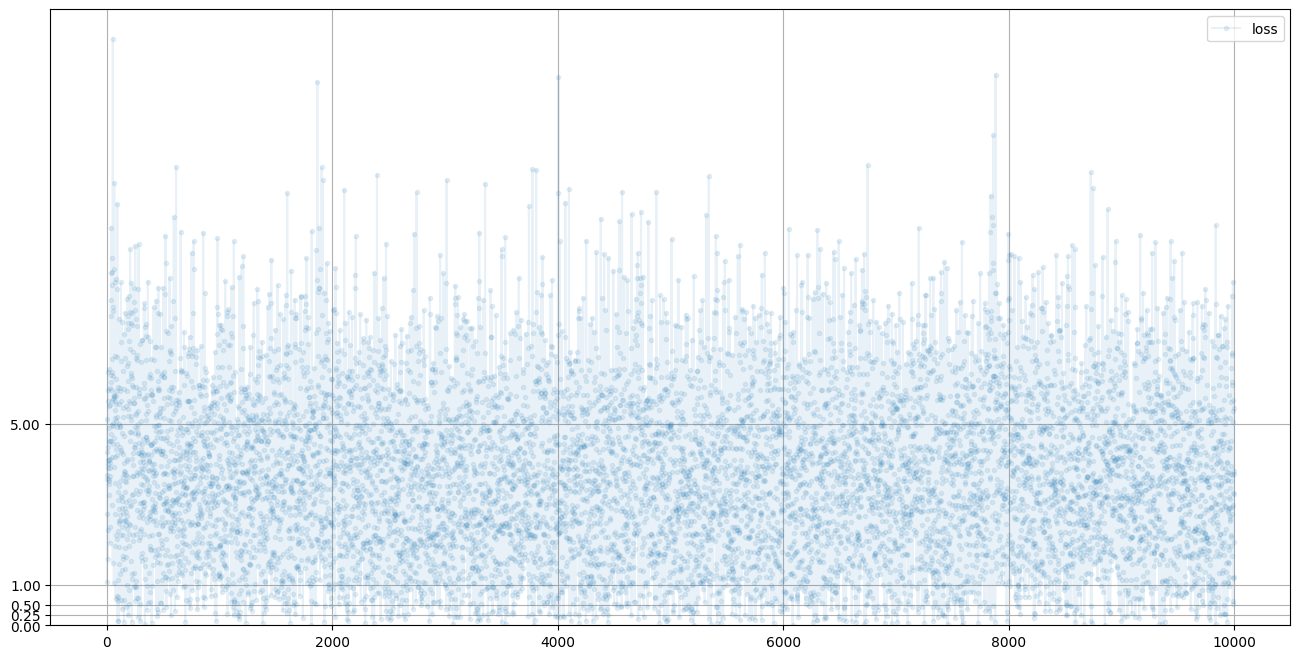

In [16]:
G.plot_progress()

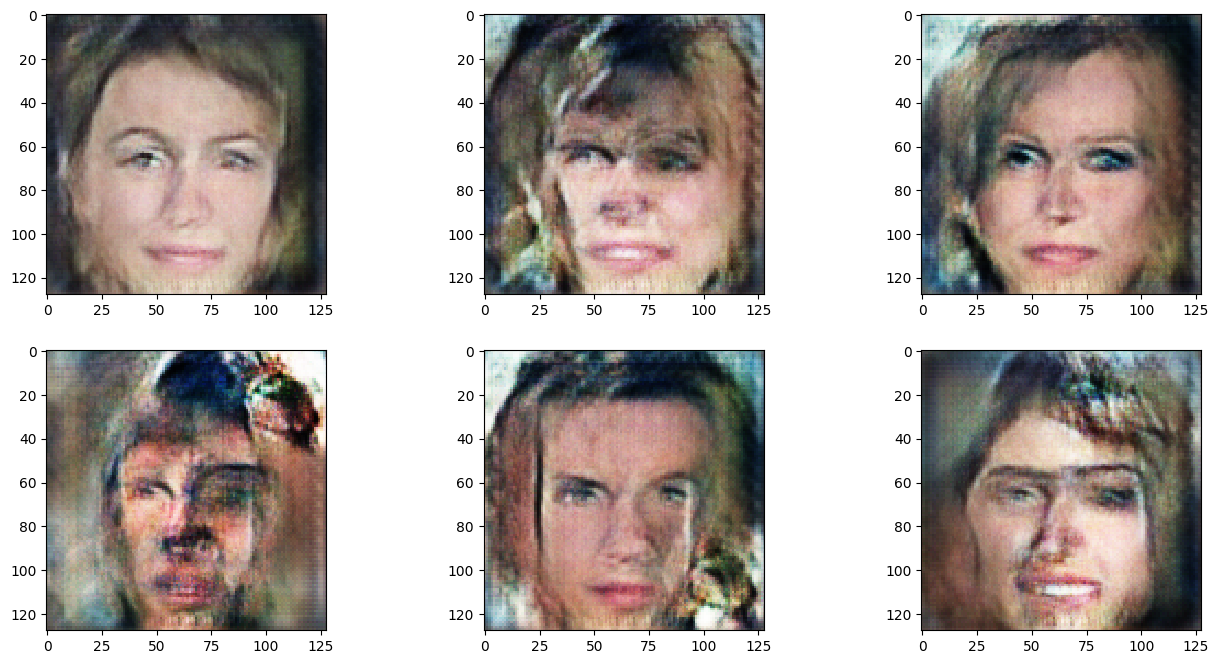

In [17]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

- 어느정도 안정된 손실 그래프
- 얼굴의 기본적인 부분은 생성하는 모습

In [18]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.28009986877441406

- 메모리 사용량 또한 매우 줄어듬

### 이외 성능을 높이기 위한 실험?